# Analytic solution for $T\to\infty$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.analysis import *
from src.theory import *

# reimport modules if they change
%load_ext autoreload
%autoreload 2

## Parameters

In [2]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
# not required for mean-field:    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'sigma': 0.01, # std of additive Gaussian noise
    'epsilon': 0.1, # error threshold for overlap
}

# this is resolution on x-axis in results figure
lams = 1 - 10 ** np.linspace(0, -4, 64 + 1)

filename = f"results/results_analytic_inf_N{params['N']}_mu{params['mu']}_epsilon{params['epsilon']}_sigma{params['sigma']}.txt"

# only do analysis if file does not exist (needs manual delete to rerun)
if os.path.exists(filename):
    raise ValueError(f"{filename} already exists.\nDelete it to rerun.")

## 1. Mean-field activity
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

In [3]:
mean_field_activity?

Signature: mean_field_activity(lam, mu, h, dt=1)
Docstring: <no docstring>
File:      ~/git/projects/sahel_finite-observation-dynamic-range/src/theory.py
Type:      function

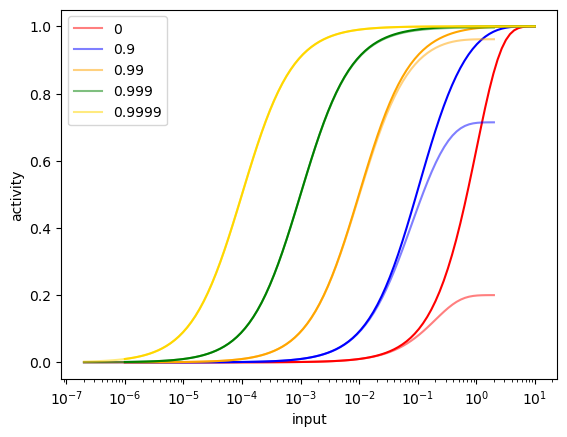

In [4]:
hs=np.logspace(-6,1,100)
colors=['red','blue','orange','green', 'gold']
for i,lam in enumerate([0,0.9,0.99,0.999, 0.9999]):
    plt.plot(hs*0.2, mean_field_activity(lam, params['mu'], hs), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, mean_field_activity(lam, 1.0, hs), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

## 2. Convolution with noisy output to estimate discriminable intervals
The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$
The output is thus a convolution between $P(a)$ and $\mathcal{N}(0,\sigma)$.

For $T\to\infty$ the distribution of activity is a delta-distribution such that the the output distribution becomes a shifted Gaussian
$$ P(o|h) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

In [5]:
x_gauss = support_gauss(bound=5 * params["sigma"], delta=1/params["N"])
support = support_conv_pmf_gauss([0,1], x_gauss)

# distribution of noisy output for global parameters
def pmf_noise(h, lam):
    a = mean_field_activity(lam, params["mu"], h)
    return stats.norm.pdf(support, a, params["sigma"] ) / params["N"]

[1.3152705591323866e-05, 2.7016106502754786e-05, 4.1649550785640885e-05, 5.711904427145929e-05, 7.349812453834629e-05, 9.08696195030545e-05, 0.00010932669546989648, 0.00012897399399719597, 0.0001499306907812005, 0.0001723324141183695, 0.00019633356127083716, 0.00022211188146187708, 0.0002498726254389868, 0.00027985333452363215, 0.00031233130129881576, 0.00034763245493126514, 0.0003861415396767748, 0.0004283162262325502, 0.0004747065201754203, 0.0005259779824483926, 0.0005829428013241289, 0.0006466056898101807, 0.0007182225372509726, 0.0007993816063792311, 0.0008921269045112833, 0.0009991313174147762, 0.001123955363254409, 0.00127145480466628, 0.0014484275776869867, 0.0016646869164144665, 0.0019349463147948754, 0.0022823207970617833, 0.002745309221791356, 0.003393142404071527, 0.0043641379302381544, 0.005980474083127359, 0.009205617319726946]
[0.01881407143322633, 0.009203729909484327, 0.005979627748355973, 0.0043636648456649415, 0.0033928405444843468, 0.002745098631712415, 0.0022821647

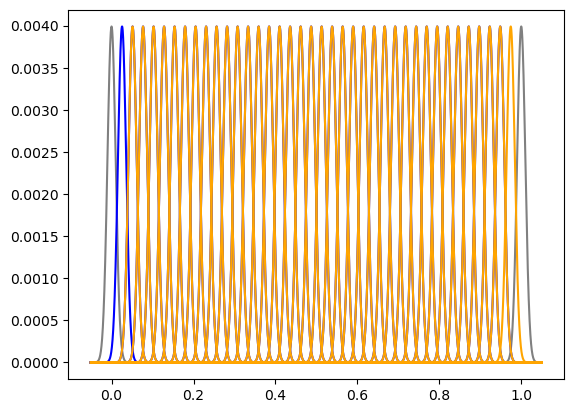

In [6]:
# specify p(o|h)
lam = 0.9999
pmf_given_h = lambda h: pmf_noise(h, lam)

h_range=[0,1e3]
pmf_ref_left = pmf_given_h(h_range[0])
pmf_ref_right = pmf_given_h(h_range[1])

plt.plot(support,pmf_ref_left, color="gray")
plt.plot(support,pmf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pmf_given_h, h_range, [pmf_ref_left, pmf_ref_right], params['epsilon'], start="left")
print(hs_left)
for h in hs_left:
    plt.plot(support,pmf_given_h(h), color="blue")

hs_right = find_discriminable_inputs(pmf_given_h,h_range, [pmf_ref_left, pmf_ref_right], params['epsilon'], start="right")
print(hs_right)
for h in hs_right:
    plt.plot(support,pmf_given_h(h), color="orange")
#plt.legend()

## 3. Final analysis of discriminable inputs as a function of lambda

In [7]:
def analyse(lam, verbose=False):
    """
        return lambda, number of discriminable intervals, dynamic range
    """
    pmf_o_given_h = lambda h: pmf_noise(h, lam)

    h_range = h_range_theory(lam, params)

    # analysis (same as pmf_noise in this particular case)
    pmf_refs = [stats.norm.pdf(support, mean_field_activity(lam, params["mu"], h), params["sigma"])/params["N"] for h in [0, np.inf]]

    # get dynamic range and number of discriminable states
    dr, nd = analysis_dr_nd(pmf_o_given_h, h_range, pmf_refs, params["epsilon"], verbose=verbose)
    
    return lam, dr, nd

In [8]:
analyse(0.9)

(0.9, 22.52258363275085, 26.0)

In [10]:
# results
drs = np.zeros(len(lams))
nds = np.zeros(len(lams))

for i, lam in tqdm(enumerate(lams), total=len(lams)):
    lam, dr, nd = analyse(lam)
    drs[i] = dr
    nds[i] = nd
    
# save data
np.savetxt(filename, np.transpose([lams, drs, nds]))

100%|██████████| 65/65 [01:06<00:00,  1.03s/it]
